In [ ]:
from google.colab import files
files.upload()

In [ ]:
!unzip archive\ \(5\).zip

In [ ]:
!ls lfw-deepfunneled

In [ ]:
!ls lfw-deepfunneled/lfw-deepfunneled | head

In [ ]:
import os

DATA_DIR = "lfw-deepfunneled/lfw-deepfunneled"

people = []
counts = {}

for person in os.listdir(DATA_DIR):
    person_path = os.path.join(DATA_DIR, person)
    if os.path.isdir(person_path):
        images = os.listdir(person_path)
        counts[person] = len(images)

sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
sorted_counts[:10]

In [ ]:
import os, random
import numpy as np

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

try:
    import torch
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except Exception:
    pass

In [ ]:
DATA_DIR = "lfw-deepfunneled/lfw-deepfunneled"

N_IDENTITIES = 100
IMAGES_PER_ID = 10

eligible = [p for p, c in counts.items() if c >= IMAGES_PER_ID]
print("Eligible identities:", len(eligible))

N_IDENTITIES_ACTUAL = min(N_IDENTITIES, len(eligible))
chosen = random.sample(eligible, N_IDENTITIES_ACTUAL)
print("Chosen identities:", len(chosen))

samples = []
for person in chosen:
    person_dir = os.path.join(DATA_DIR, person)
    imgs = [f for f in os.listdir(person_dir) if f.lower().endswith(".jpg")]
    picked = random.sample(imgs, IMAGES_PER_ID)
    for fn in picked:
        samples.append((os.path.join(person_dir, fn), person))

print("Total samples:", len(samples))
samples[:3]

In [ ]:
import cv2

IMG_SIZE = 160
BLUR_K = (21, 21)

def read_rgb(path, size=IMG_SIZE):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    return img

def gaussian_blur(rgb, k=BLUR_K):
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    bgr = cv2.GaussianBlur(bgr, k, 0)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

In [ ]:
# 1 example for original vs blur
import matplotlib.pyplot as plt

p0, person0 = samples[0]
img0 = read_rgb(p0)
img0b = gaussian_blur(img0)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img0); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img0b); plt.title("Blur"); plt.axis("off")
plt.show()
print("Identity:", person0, "| Path:", p0)

In [ ]:
!pip install insightface onnxruntime

In [ ]:
from insightface.app import FaceAnalysis

app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640))

In [ ]:
faces = app.get(img0)
len(faces)

In [ ]:
def pick_main_face(faces):
    areas = []
    for f in faces:
        x1, y1, x2, y2 = f.bbox
        areas.append((x2 - x1) * (y2 - y1))
    return faces[int(np.argmax(areas))]

faces = app.get(img0)
main_face = pick_main_face(faces)
emb = main_face.embedding

print("Detected faces:", len(faces))
print("Embedding shape:", emb.shape)

In [ ]:
from tqdm import tqdm

Z_orig = []
Z_blur = []
labels = []
kept_paths = []

for path, person in tqdm(samples):

    img = read_rgb(path)
    if img is None:
        continue

    # ORIGINAL
    faces_orig = app.get(img)
    if len(faces_orig) == 0:
        continue
    main_orig = pick_main_face(faces_orig)

    # BLUR
    img_blur = gaussian_blur(img)
    faces_blur = app.get(img_blur)
    if len(faces_blur) == 0:
        continue
    main_blur = pick_main_face(faces_blur)

    Z_orig.append(main_orig.normed_embedding)
    Z_blur.append(main_blur.normed_embedding)
    labels.append(person)
    kept_paths.append(path)

Z_orig = np.array(Z_orig)
Z_blur = np.array(Z_blur)
labels = np.array(labels)

print("Final shapes:")
print("Original:", Z_orig.shape)
print("Blur:", Z_blur.shape)
print("Labels:", labels.shape)
print("Kept paths:", len(kept_paths))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

def pca_2d(Z):
    Zs = StandardScaler(with_mean=True, with_std=True).fit_transform(Z)
    pca = PCA(n_components=2, random_state=42)
    Y = pca.fit_transform(Zs)
    evr = pca.explained_variance_ratio_
    return Y, evr

Y_orig, evr_orig = pca_2d(Z_orig)
Y_blur, evr_blur = pca_2d(Z_blur)

print("Explained variance (2D) - Original:", evr_orig, "sum=", evr_orig.sum())
print("Explained variance (2D) - Blur:", evr_blur, "sum=", evr_blur.sum())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pca(Y, labels, title, n_ids=20):
    uniq = np.unique(labels)
    show = set(uniq[:n_ids])
    mask = np.array([l in show for l in labels])

    plt.figure(figsize=(7,6))
    plt.scatter(Y[mask, 0], Y[mask, 1], s=10)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plot_pca(Y_orig, labels, "PCA of ArcFace Embeddings (Original)")
plot_pca(Y_blur, labels, "PCA of ArcFace Embeddings (Gaussian Blur)")

In [ ]:
def separability_metrics(Y, labels):
    ids = np.unique(labels)
    centroids = {i: Y[labels==i].mean(axis=0) for i in ids}

    intra = []
    for i in ids:
        Xi = Y[labels==i]
        ci = centroids[i]
        intra.append(np.mean(np.sum((Xi - ci)**2, axis=1)))
    intra_var = float(np.mean(intra))

    c = np.vstack([centroids[i] for i in ids])   # mean pairwise centroid dist
    dists = []
    for a in range(len(ids)):
        for b in range(a+1, len(ids)):
            dists.append(np.linalg.norm(c[a]-c[b]))
    inter_centroid = float(np.mean(dists))

    return intra_var, inter_centroid

intra_o, inter_o = separability_metrics(Y_orig, labels)
intra_b, inter_b = separability_metrics(Y_blur, labels)

df = pd.DataFrame({
    "regime": ["original", "blur"],
    "intra_var": [intra_o, intra_b],
    "inter_centroid_dist": [inter_o, inter_b],
    "evr2_sum": [evr_orig.sum(), evr_blur.sum()]
})

df

Face Swapper

In [ ]:
!pip -q install huggingface_hub

from huggingface_hub import hf_hub_download
import os

os.makedirs("/root/.insightface/models", exist_ok=True)

model_path = hf_hub_download(
    repo_id="Aitrepreneur/insightface",
    filename="inswapper_128.onnx",
    local_dir="/root/.insightface/models",
    local_dir_use_symlinks=False
)

print("Downloaded to:", model_path)

In [ ]:
from insightface.model_zoo import get_model

swapper = get_model("/root/.insightface/models/inswapper_128.onnx", download=False)
print("Swapper loaded:", type(swapper))

In [ ]:
import hashlib

def deterministic_donor_id(target_id, other_ids, path, seed=SEED):
    key = f"{seed}|{target_id}|{path}".encode("utf-8")
    h = int(hashlib.md5(key).hexdigest(), 16)
    return other_ids[h % len(other_ids)]

def gan_swap(img_rgb, donor_face_obj):
    faces = app.get(img_rgb)
    if len(faces) == 0:
        return None
    target_face = pick_main_face(faces)
    swapped = swapper.get(img_rgb, target_face, donor_face_obj, paste_back=True)
    return swapped

In [ ]:
from tqdm import tqdm

donor_face_by_id = {}

for person in np.unique(labels):
    person_paths = [p for (p, lab) in samples if lab == person]
    if len(person_paths) == 0:
        continue

    person_paths_sorted = sorted(person_paths)
    idx = int(hashlib.md5(f"{SEED}|{person}".encode()).hexdigest(), 16) % len(person_paths_sorted)
    pth = person_paths_sorted[idx]

    img = read_rgb(pth)
    if img is None:
        continue

    faces = app.get(img)
    if len(faces) == 0:
        continue

    donor_face_by_id[person] = pick_main_face(faces)

print("Donor faces computed:", len(donor_face_by_id))

In [ ]:
Z_gan = []
labels_gan = []
kept_paths_gan = []

valid_ids = list(donor_face_by_id.keys())
valid_set = set(valid_ids)

for path, person in tqdm(zip(kept_paths, labels), total=len(labels)):
    if person not in valid_set:
        continue

    img = read_rgb(path)
    if img is None:
        continue

    other_ids = [i for i in valid_ids if i != person]
    if len(other_ids) == 0:
        continue

    donor_id = deterministic_donor_id(person, other_ids, path, seed=SEED)
    donor_face = donor_face_by_id[donor_id]

    swapped = gan_swap(img, donor_face)
    if swapped is None:
        continue

    faces_swapped = app.get(swapped)
    if len(faces_swapped) == 0:
        continue

    main_swapped = pick_main_face(faces_swapped)

    Z_gan.append(main_swapped.normed_embedding)
    labels_gan.append(person)
    kept_paths_gan.append(path)

Z_gan = np.array(Z_gan)
labels_gan = np.array(labels_gan)

print("GAN embeddings shape:", Z_gan.shape)
print("GAN labels shape:", labels_gan.shape)

In [ ]:
Y_gan, evr_gan = pca_2d(Z_gan)
intra_g, inter_g = separability_metrics(Y_gan, labels_gan)

print("Explained variance (2D) - GAN:", evr_gan, "sum=", evr_gan.sum())
print("Intra-class variance (GAN):", intra_g)
print("Inter-centroid distance (GAN):", inter_g)

In [ ]:
def plot_two_pca_separate(Y_left, labels_left,
                          Y_right, labels_right,
                          title_left, title_right,
                          n_ids=20,
                          save_path=None):

    ids = np.unique(labels_left)[:n_ids]

    fig, axes = plt.subplots(1, 2, figsize=(10,4))

    for u in ids:
        mask_left = labels_left == u
        mask_right = labels_right == u

        axes[0].scatter(Y_left[mask_left, 0],
                        Y_left[mask_left, 1], s=12)

        axes[1].scatter(Y_right[mask_right, 0],
                        Y_right[mask_right, 1], s=12)

    axes[0].set_title(title_left)
    axes[1].set_title(title_right)

    axes[0].set_xlabel("PC1")
    axes[0].set_ylabel("PC2")
    axes[1].set_xlabel("PC1")
    axes[1].set_ylabel("PC2")

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [ ]:
# matching original PCA points for GAN-survived samples
path_to_Yorig = {p: y for p, y in zip(kept_paths, Y_orig)}
Y_orig_for_gan = np.array([path_to_Yorig[p] for p in kept_paths_gan])

plot_two_pca_separate(Y_orig_for_gan, labels_gan, Y_gan, labels_gan,
                      "Original", "GAN Swap", n_ids=20)

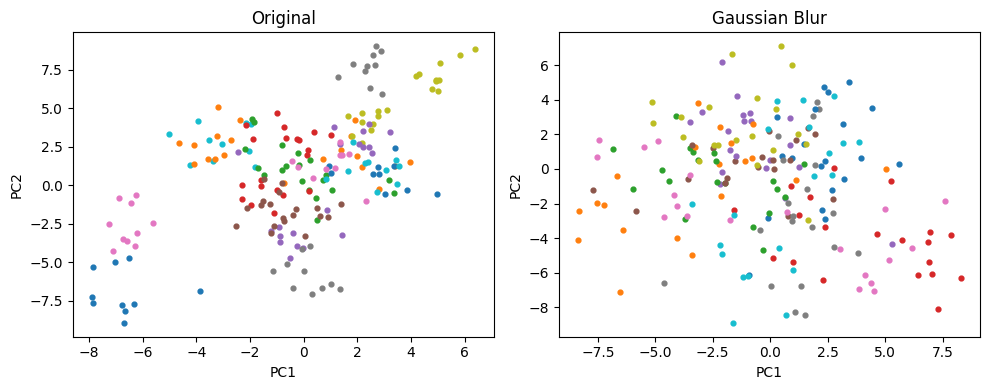

In [75]:
plot_two_pca_separate(Y_orig, labels,
                      Y_blur, labels,
                      "Original", "Gaussian Blur",
                      n_ids=20,
                      save_path="fig1_pca_orig_blur.png")

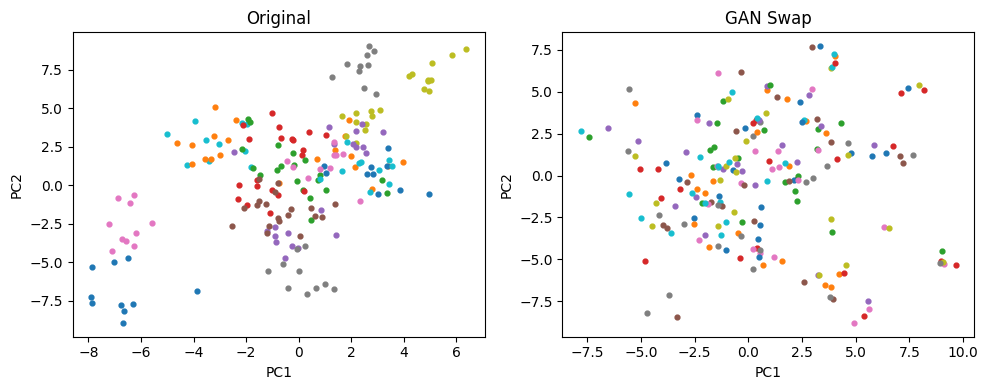

In [76]:
plot_two_pca_separate(Y_orig_for_gan, labels_gan,
                      Y_gan, labels_gan,
                      "Original", "GAN Swap",
                      n_ids=20,
                      save_path="fig2_pca_orig_gan.png")

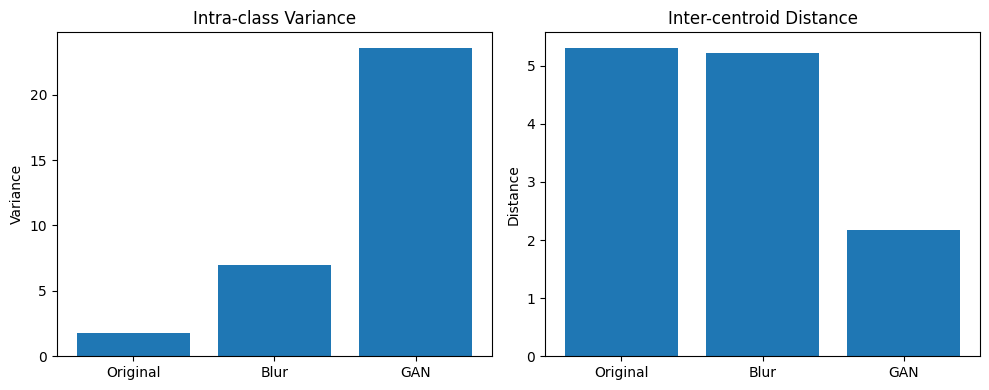

Saved fig3_metrics.png


In [77]:
import matplotlib.pyplot as plt

regimes = ["Original", "Blur", "GAN"]
intra_vals = [intra_o, intra_b, intra_g]
inter_vals = [inter_o, inter_b, inter_g]

fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Intra-class variance
axes[0].bar(regimes, intra_vals)
axes[0].set_title("Intra-class Variance")
axes[0].set_ylabel("Variance")

# Inter-centroid distance
axes[1].bar(regimes, inter_vals)
axes[1].set_title("Inter-centroid Distance")
axes[1].set_ylabel("Distance")

plt.tight_layout()
plt.savefig("fig3_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved fig3_metrics.png")